# Mackeral Egg Data
This example gives an example of 2D spatial interactions, using data from a fish egg survey. The key features in the data are:

- **egg.count** - number of eggs found in the net
- **c.dist** - distance from 200m seabed contour
- **b.depth** - depth of the ocean
- **temp.surf** - surface temperature of the ocean
- **temp.20m** - water temperature at a depth of 20 meters
- **lat** - latitude
- **lon** - longitude
- **salinity** - net.area the area of the net used in m2


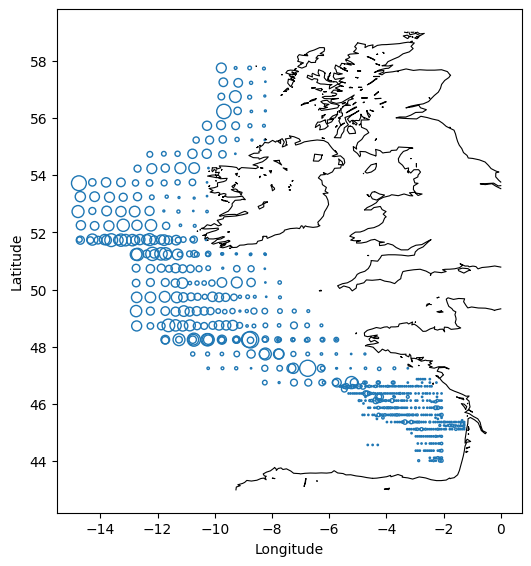

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymgcv.plot as gplt
from pymgcv import families as fam
from pymgcv.gam import GAM
from pymgcv.terms import Offset, S
from pymgcv.utils import load_rdata_dataframe_from_url


def get_data():
    data = load_rdata_dataframe_from_url(
        "https://github.com/cran/gamair/raw/master/data/mack.rda",
)
    data.columns = [col.replace(".", "_") for col in data.columns]
    data["log_net_area"] = np.log(data["net_area"]) 
    data["root_b_depth"] = data["b_depth"]**0.5
    data = data.drop(columns=["country", "vessel"])

    coast = load_rdata_dataframe_from_url(
        "https://github.com/cran/gamair/raw/master/data/coast.rda",
)

    # NaN rows split coast data into "segments", so we manually seperate them
    segments = coast.dropna().groupby(coast['lon'].isna().cumsum())
    return data, segments

data, segments = get_data()

fig, ax = plt.subplots(figsize=(6, 8))

for _, seg in segments:
    ax.plot(seg['lon'], seg['lat'], color="k", linewidth=0.8)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")  # keep correct aspect ratio

ax.scatter(
    data["lon"], data["lat"], s=1+ data["egg_count"], facecolors='none', edgecolors='C0',
);

Let's look at some key features

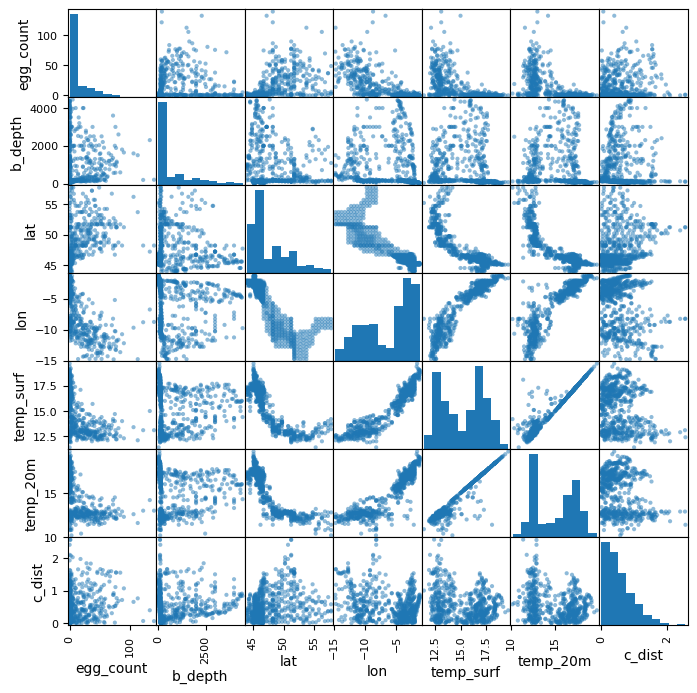

In [2]:
to_plot = [
    "egg_count",
    "b_depth",
    "lat",
    "lon",
    "temp_surf",
    "temp_20m",
    "c_dist",
]

pd.plotting.scatter_matrix(data[to_plot], figsize=(8, 8))
plt.show()


We'll try fitting a Poisson GAM.

!!! note "Offsets"

    We know that the number of eggs captured is likely proportional to the net area. We can encode this belief by including an [`Offset`][pymgcv.terms.Offset] term. Given all the families considered here use a log link function, we can use `Offset("log_net_area")`.

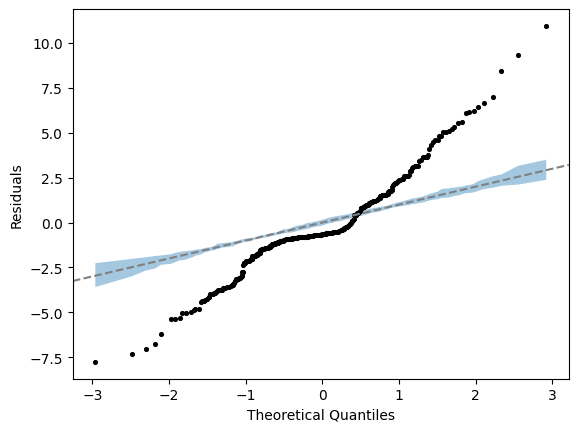

In [3]:
gam1 = GAM({"egg_count" : S("c_dist")
      + S("root_b_depth")
      + S("temp_surf")
      + S("temp_20m")
      + S("lat")
      + S("lon")
      + S("salinity")
      + Offset("log_net_area"), # Account for varying net size!
      }, family = fam.Poisson())

# The data contains NaNs: subset to only required data, then drop nan rows
data = data[gam1.referenced_variables]
data = data[~data.isna().any(axis=1)]
gam1.fit(data=data)
gplt.qq(gam1)
plt.show()

 That does not look good! The residuals are overdispersed. Maybe a negative binomial or tweedie is better?

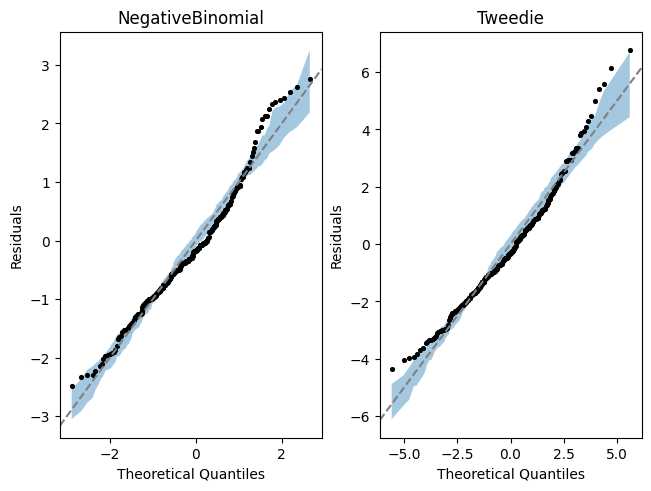

In [4]:
models = {
    "NegativeBinomial": GAM(gam1.predictors, family=fam.NegativeBinomial()),
    "Tweedie": GAM(gam1.predictors, family=fam.Tw()),
     }
     
fig, axes = plt.subplots(ncols=2, layout="constrained")
for ax, (name, model) in zip(axes, models.items(), strict=True):
    model.fit(data=data)
    gplt.qq(model, ax=ax)
    ax.set_title(name)

plt.show()

They look better, we'll continue with Tweedie. Let's spatially check the residuals

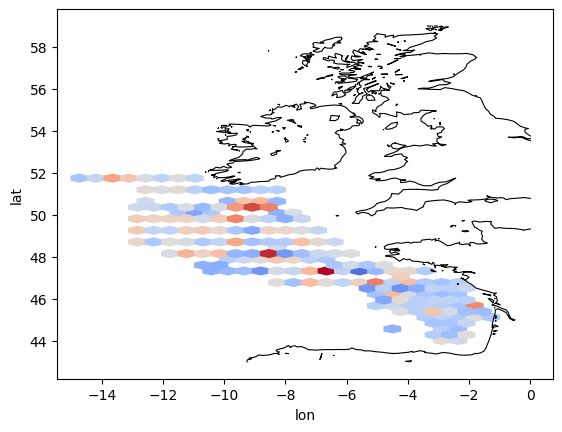

In [5]:
model = models["Tweedie"]
residuals = model.residuals()
max_val = np.max(np.abs(residuals))  # Set to match on both plots
ax = gplt.hexbin_residuals(residuals, "lon", "lat", data=data, max_val=max_val)

for _, seg in segments:
    ax.plot(seg['lon'], seg['lat'], color="k", linewidth=0.8)

It looks like there is a spatial relationship in the residuals, with regions with predominantly positive or negative residuals. We can try to address this by adding a bivariate smooth for lattitude and longitude

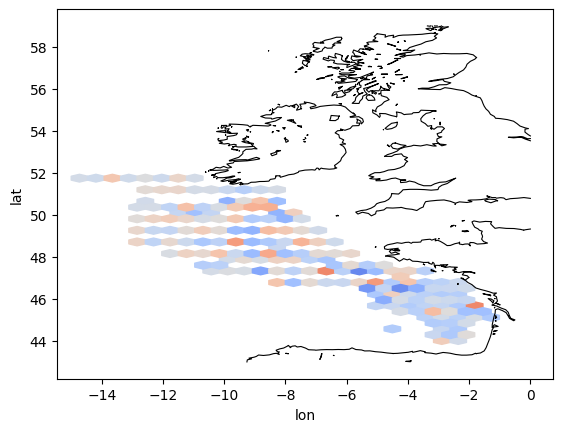

In [6]:
bivariate_model = GAM(
    {
        "egg_count": (
            S("c_dist")
            + S("root_b_depth")
            + S("temp_surf")
            + S("temp_20m")
            + S("lon", "lat", k=100)
            + S("salinity")
            + Offset("log_net_area")
        ),
    },
    family=fam.Tw(),
)
bivariate_model.fit(data=data)
residuals = bivariate_model.residuals()

ax = gplt.hexbin_residuals(residuals, "lon", "lat", data=data, max_val=max_val) 

for _, seg in segments:
    ax.plot(seg['lon'], seg['lat'], color="k", linewidth=0.8)


That seems to have helped! Let's take a look at the fitted smooths.

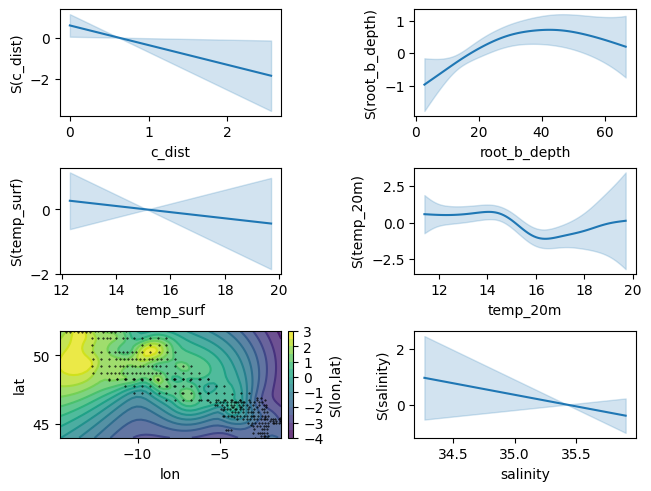

In [7]:
fig, axes = gplt.plot(
    bivariate_model,
    to_plot=S,
    )

# Helpful to see datapoints on 2d plot to assess extrapolation risks
axes[4].scatter(
    data["lon"], data["lat"], s=0.2, color="black", zorder=2,
)

# Adjust y-label format
for ax in axes.flatten():
    ax.set_ylabel(ax.get_ylabel().replace("~", "\n~"))
